## Imports

In [3]:
import pandas as pd
import re
import timeit
#import lightgbm as lgb
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
set_visualize_provider(InlineProvider())

warnings.filterwarnings("ignore")

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression



## Funció Alineament de Dades

In [4]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [5]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [6]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [7]:
# Carregar dades Alt Ter
def loadDataTer(nom, Ter):
    
    altTer = prepareDFMod(Ter, nom)
    
    return altTer

In [8]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [9]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [10]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [11]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [12]:
#Carregar Dades Comparatives

#Alinear Ripoll
ripoll = loadDataTer("L17147-72-00005", altTer)
ripoll = alignSeries(ripoll, 150)

#Alinear Sant Joan
santJoan = loadDataTer("L17167-72-00001", altTer)
santJoan = alignSeries(santJoan, 180)

#Alinear DG
DG = loadDataPrecipitacions("DG", precipitacions)
DG = alignSeries(DG, 270)

#Alinear CG 
CG = loadDataPrecipitacions("CG", precipitacions)
CG = alignSeries(CG, 300)

#Alinear CI
CI = loadDataPrecipitacions("CI", precipitacions)
CI = alignSeries(CI, 150)

#Alinear V4
V4 = loadDataPrecipitacions("V4", precipitacions)
V4 = alignSeries(V4, 180)

#Alinear CC
CC = loadDataPrecipitacions("CC", precipitacions)
CC = alignSeries(CC, 195)

#Alinear CY
CY = loadDataPrecipitacions("CY", precipitacions)
CY = alignSeries(CY, 240)

#Alinear VN
VN = loadDataPrecipitacions("VN", precipitacions)
VN = alignSeries(VN, 300)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 300)

#Alinear V3

V3 = loadDataPrecipitacions("V3", precipitacions)
V3 = alignSeries(V3, 210)

#Z4_ZC

In [13]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfAltX = pd.DataFrame(index=range(len(idx)))
dfAltX["L17147-72-00005"] = pd.Series(ripoll.tolist())
dfAltX["L17167-72-00001"] = pd.Series(santJoan.tolist())
dfAltX['DG'] = pd.Series(DG.tolist())
dfAltX['CG'] = pd.Series(CG.tolist())
dfAltX['CI'] = pd.Series(CI.tolist())
dfAltX['V4'] = pd.Series(V4.tolist())
dfAltX['CC'] = pd.Series(CC.tolist())
dfAltX['CY'] = pd.Series(CY.tolist())
dfAltX['VN'] = pd.Series(VN.tolist())
dfAltX['WS'] = pd.Series(WS.tolist())
dfAltX['V3'] = pd.Series(V3.tolist())



In [14]:
#Assignem les hores al index
dfAltX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfAltX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfAltX.drop(dfAltX.head(posToMove).index, inplace=True)
dfAltX.drop(dfAltX.tail(1).index, inplace=True)
dfAltX.fillna(0, inplace=True)


In [15]:
#Eliminem les mateixes columnes del 
masies = loadDataTer("L08116-72-00002", altTer)
masies.rename(columns={'data':'L08116-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
masies.drop(masies.head(posToMove).index, inplace=True)
dfAltY = masies
dfAltX.fillna(0, inplace=True)
dfAltY.fillna(0, inplace=True)

In [16]:
#Guardem el matrix de X y el array de y en un csv

dfAltX.to_csv('dfAltX.csv')
dfAltY.to_csv('dfAltY.csv')

# Alineament del DataFrame amb Referencia (Baix Ter)

In [16]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [17]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [18]:
#Carregar Dades Comparatives

#Alinear L17199-72-00001

L171997200001 = loadDataTer("L17199-72-00001", baixTer)
L171997200001 = alignSeries(L171997200001, 300)

#Alinear F026458

F026458 = loadDataTer("F026458", baixTer)
F026458 = alignSeries(F026458, 300)

#Alinear F001242
F001242 = loadDataTer("F001242", baixTer)
F001242 = alignSeries(F001242, 300)

#Alinear L170797200005
L170797200005 = loadDataTer("L17079-72-00005", baixTer)
L170797200005 = alignSeries(L170797200005, 270)

#Alinear L17079-72-00004

L170797200004 = loadDataTer("L17079-72-00004", baixTer)
L170797200004 = alignSeries(L170797200004, 270)

#Alinear L17038-72-00002

L170387200002 = loadDataPrecipitacions("L17038-72-00002", baixTer)
L170387200002 = alignSeries(L170387200002, 270)

#Alinear KE
KE = loadDataPrecipitacions("KE", precipitacions)
KE = alignSeries(KE, 300)

#Alinear UO
UO = loadDataPrecipitacions("UO", precipitacions)
UO = alignSeries(UO, 480)

#Alinear UN
UN = loadDataPrecipitacions("UN", precipitacions)
UN = alignSeries(UN, 405)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 270)

#Alinear DJ

DJ = loadDataPrecipitacions("DJ", precipitacions)
DJ = alignSeries(DJ, 360)



In [19]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfBaixX = pd.DataFrame(index=range(len(idx)))
dfBaixX["L17199-72-00001"] = pd.Series(L171997200001.tolist())
dfBaixX["F026458"] = pd.Series(F026458.tolist())
dfBaixX['F001242'] = pd.Series(F001242.tolist())
dfBaixX['L17079-72-00005'] = pd.Series(L170797200005.tolist())
dfBaixX['L17079-72-00004'] = pd.Series(L170797200004.tolist())
dfBaixX['L17038-72-00002'] = pd.Series(L170387200002.tolist())
dfBaixX['KE'] = pd.Series(KE.tolist())
dfBaixX['UO'] = pd.Series(UO.tolist())
dfBaixX['UN'] = pd.Series(UN.tolist())
dfBaixX['WS'] = pd.Series(WS.tolist())
dfBaixX['DJ'] = pd.Series(DJ.tolist())




In [20]:
#Assignem les hores al index
dfBaixX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfBaixX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfBaixX.drop(dfBaixX.head(posToMove).index, inplace=True)
dfBaixX.drop(dfBaixX.tail(1).index, inplace=True)
dfBaixX.fillna(0, inplace=True)

In [21]:
#Eliminem les mateixes columnes del 
colomers = loadDataTer("L17055-72-00002", baixTer)
colomers.rename(columns={'data':'L17055-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
colomers.drop(colomers.head(posToMove).index, inplace=True)
dfBaixY = colomers
dfBaixX.fillna(0, inplace=True)
dfBaixY.fillna(0, inplace=True)

In [22]:
#Guardem el matrix de X y el array de y en un csv

dfBaixX.to_csv('dfBaixX.csv')
dfBaixY.to_csv('dfBaixY.csv')

# Models Alt Ter

# Random Forest (Alt Ter)

In [41]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [ ]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [17]:
df_results_altTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

In [ ]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
   
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [ ]:
df_results_altTer

# XGBoost (Alt Ter)

In [ ]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [ ]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [ ]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    ebm = ExplainableBoostingClassifier()
    ebm.fit(Df_AltX_train, Df_Alty_train)
    
    ebm_global = ebm.explain_global()
    show(ebm_global)
    
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    ebm_local1 = ebm.explain_local(plotXtestAnomaly1, plotYtestAnomaly1)
    show(ebm_local1)
    ebm_local2 = ebm.explain_local(plotXtestAnomaly2, plotYtestAnomaly2)
    show(ebm_local2)
    ebm_local3 = ebm.explain_local(plotXtestStandard1, plotYtestStandard1)
    show(ebm_local3)
    ebm_local4 = ebm.explain_local(plotXtestStandard2, plotYtestStandard2)
    show(ebm_local3)
    

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [ ]:
df_results_altTer

## LightGBM (Alt Ter)

In [46]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [47]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [51]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
     'task' : ['predict'],
     'boosting': ['gbdt' ],
     'objective': ['root_mean_squared_error'],
     'num_iterations': [  1500, 2000,5000  ],
     'learning_rate':[  0.05, 0.005 ],
    'num_leaves':[ 7, 15, 31  ],
    'max_depth' :[ 10,15,25],
    'min_data_in_leaf':[15,25 ],
   'feature_fraction': [ 0.6, 0.8,  0.9],
     'bagging_fraction': [  0.6, 0.8 ],
     'bagging_freq': [   100, 200, 400  ],
     
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = lgb.LGBMRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'XGBoost','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

Iteració:  1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
CPU times: total: 51.7 s
Wall time: 5min 1s


UFuncTypeError: Cannot cast ufunc 'true_divide' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

In [ ]:
df_results_altTer

# Explainable Boosting Machines (Alt Ter)

In [46]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [47]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [51]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)


iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExplainableBoostingMachine()
    ebm = ExplainableBoostingClassifier()
    ebm.fit(Df_AltX_train, Df_Alty_train)
    
    ebm_global = ebm.explain_global()
    show(ebm_global)
    
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    ebm_local1 = ebm.explain_local(plotXtestAnomaly1, plotYtestAnomaly1)
    ebm_local2 = ebm.explain_local(plotXtestAnomaly2, plotYtestAnomaly2)
    ebm_local3 = ebm.explain_local(plotXtestStandard1, plotYtestStandard1)
    ebm_local4 = ebm.explain_local(plotXtestStandard2, plotYtestStandard2)
    

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

Iteració:  1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
CPU times: total: 51.7 s
Wall time: 5min 1s


UFuncTypeError: Cannot cast ufunc 'true_divide' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

In [ ]:
df_results_altTer

# ExtraTrees (Alt Ter)

In [ ]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [ ]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [ ]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
   
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Extra Trees','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [ ]:
df_results_altTer

# Linear Regression (Alt Ter)

In [ ]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [ ]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

In [ ]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltX_train, Df_Alty_train)
        
    score = modelfited.score(Df_AltX_test, Df_Alty_test)
    
    predicty = modelfited.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    

    hores = "1 day"
    
    
    
    joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [ ]:
df_results_altTer

# Models Baix Ter

# Random Forest (Baix Ter)

In [22]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [23]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

In [24]:
df_results_baixTer = pd.DataFrame(columns = ["Method", "Best_Params", "Features","Feature_Importance", "Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 4.22 s
Wall time: 24.6 s


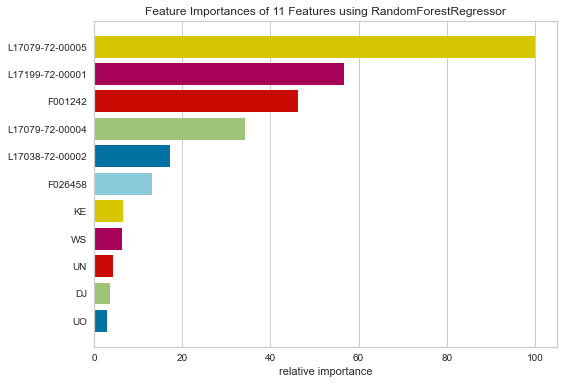

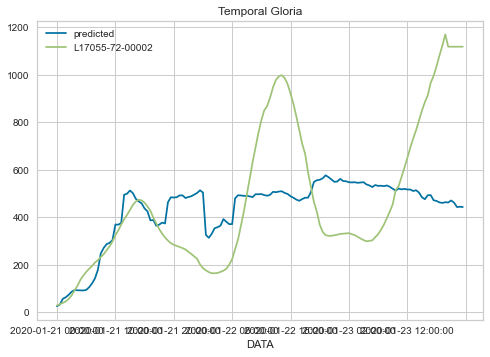

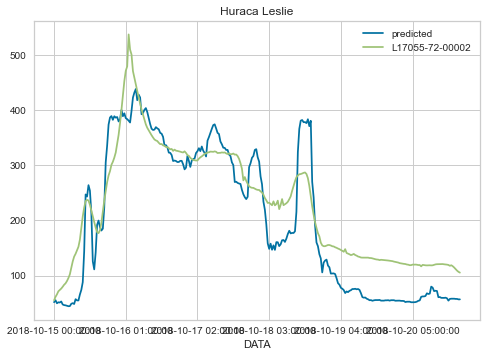

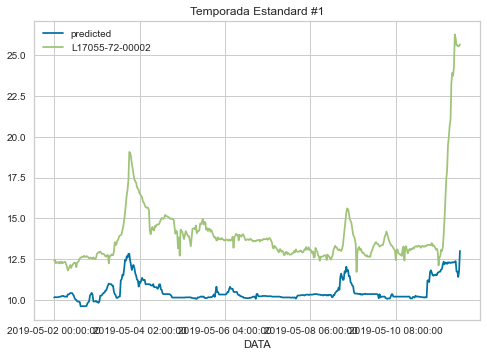

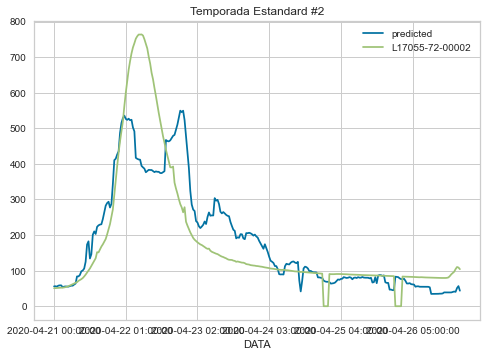

Iteració:  2
CPU times: total: 6.23 s
Wall time: 35.2 s


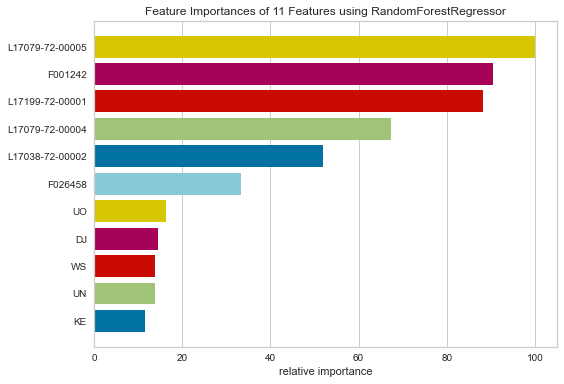

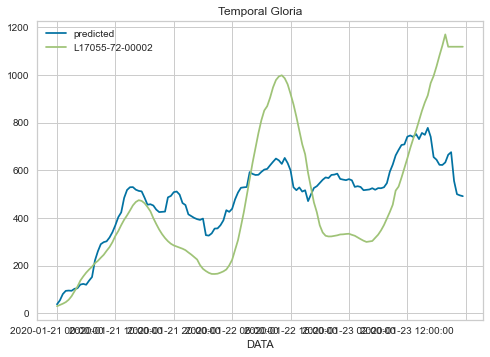

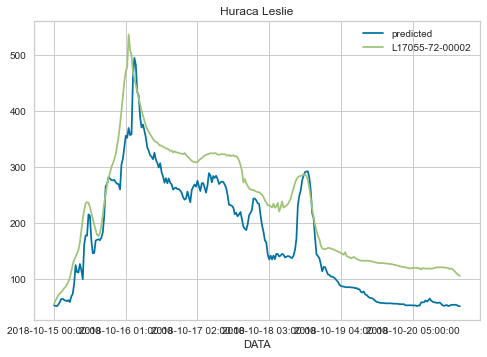

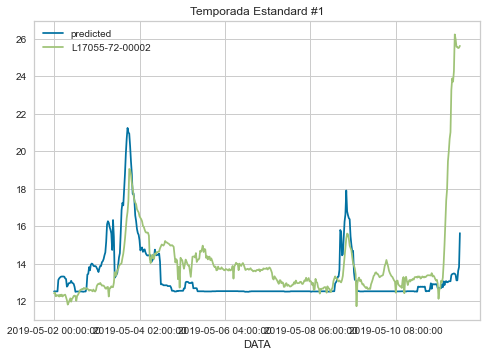

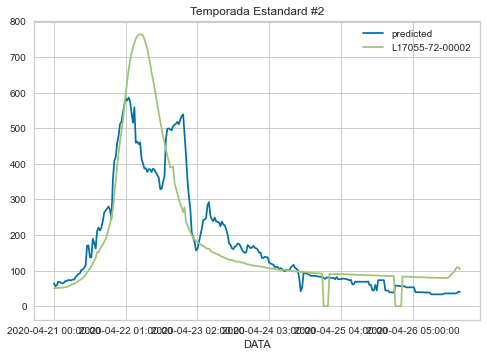

Iteració:  3
CPU times: total: 28.9 s
Wall time: 1min 57s


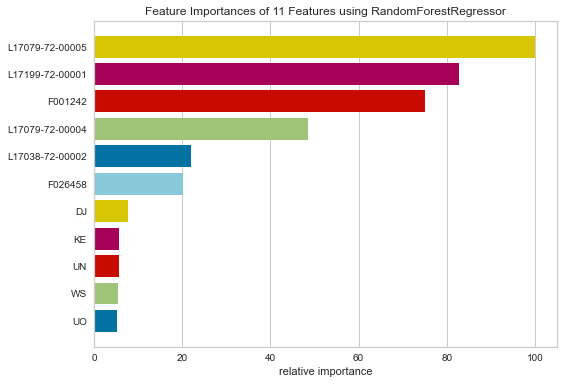

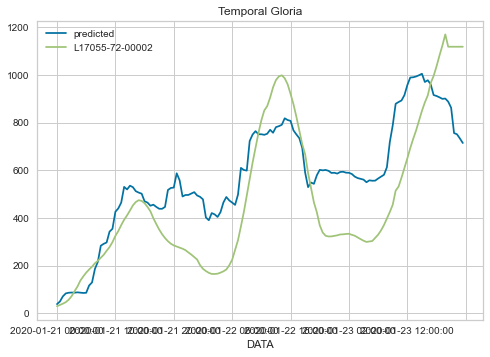

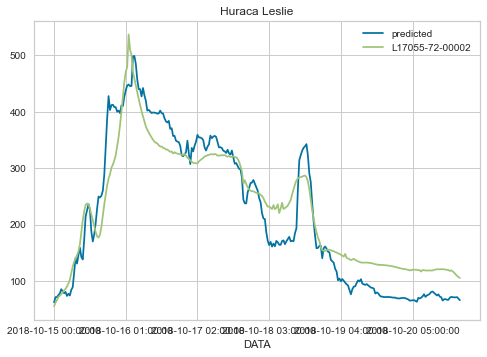

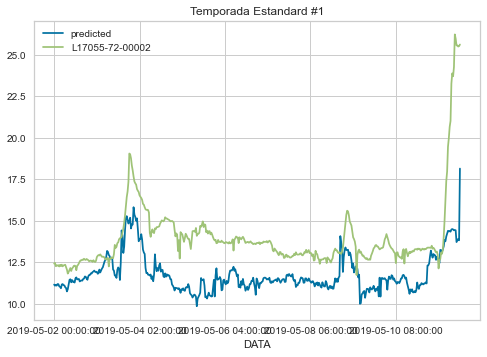

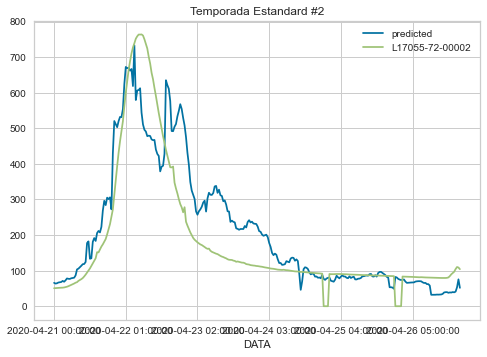

Time:  0:03:00.297711


In [25]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [26]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores,RMSE_Leslie,RMSE_Standard1,RMSE_Standard2,RSME_Gloria
0,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.19457417609467156, 0.04548927990487396, 0.1...",0.756907,NaN,1 day,56.824224,3.846712,105.936538,275.321240
1,Random Forest,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1760615586056166, 0.06632250998624659, 0.18...",0.540035,NaN,1 day,62.472393,2.250157,97.057859,221.484833
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.21864924772908742, 0.05323183814057408, 0.1...",0.69618,NaN,1 day,44.909047,2.745626,97.221138,201.039507


# XGBoost (Baix Ter)

In [27]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [28]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

Iteració:  1
[23:18:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 50 s
Wall time: 59.6 s


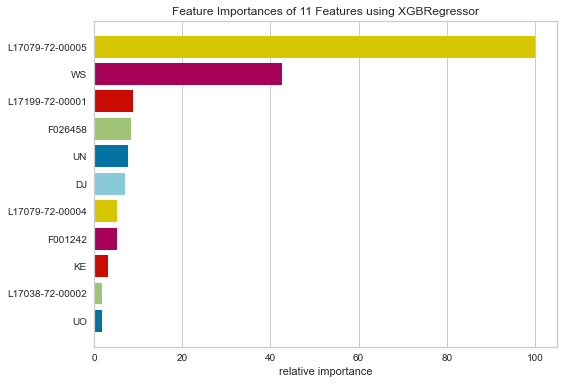

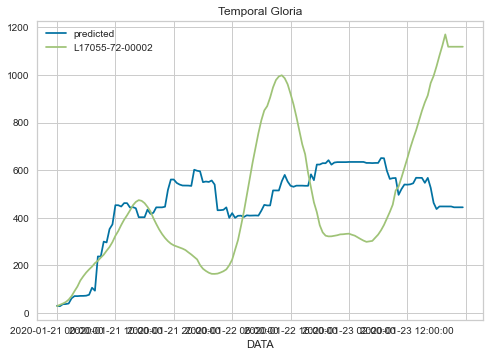

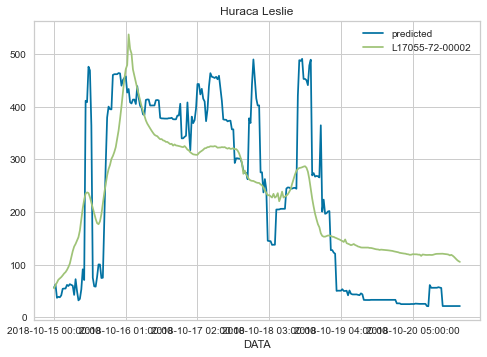

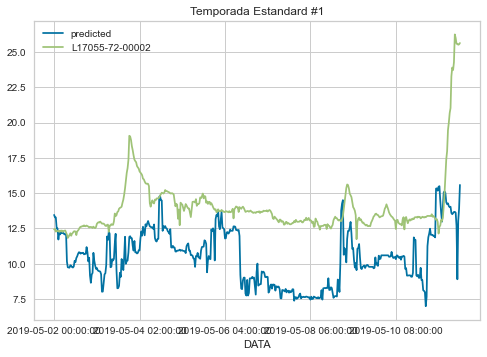

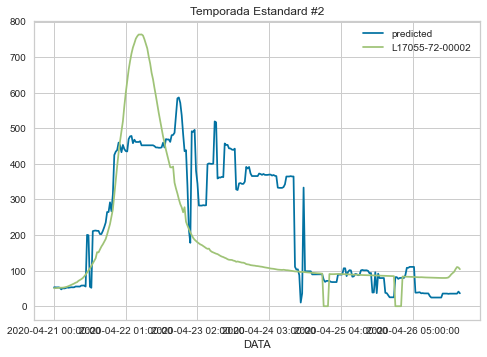

Iteració:  2
[23:19:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 15 s
Wall time: 27.7 s


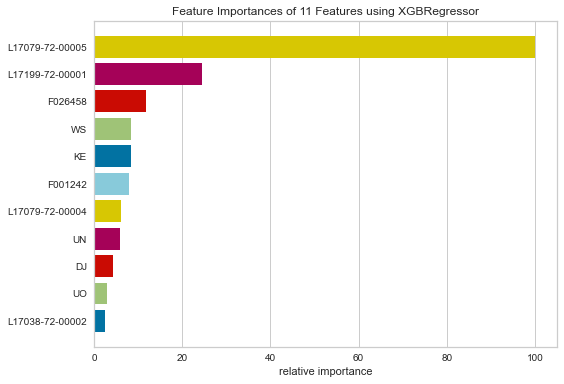

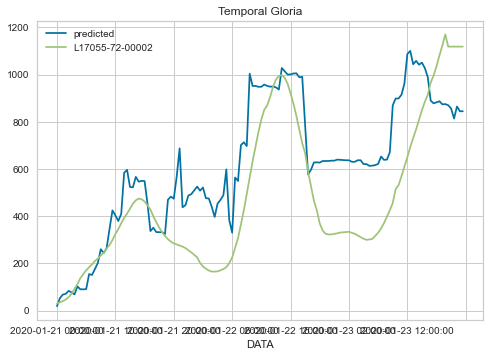

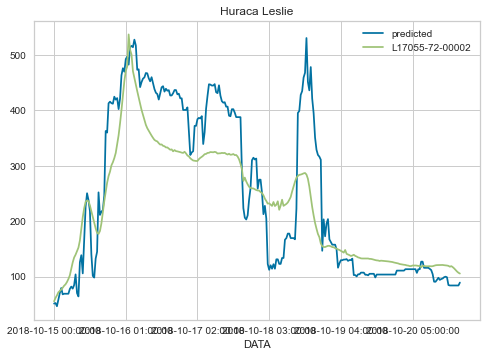

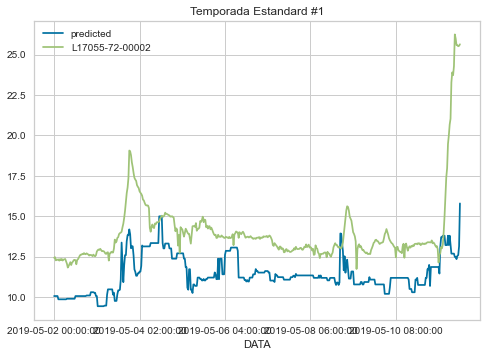

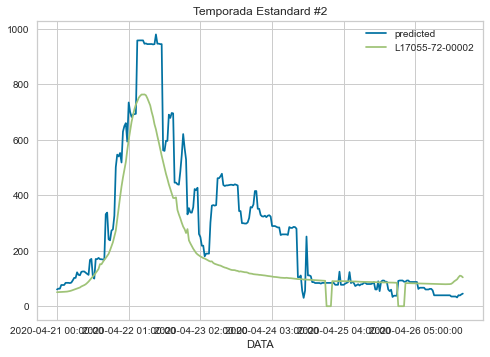

Iteració:  3
[23:23:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 3min 58s
Wall time: 4min 51s


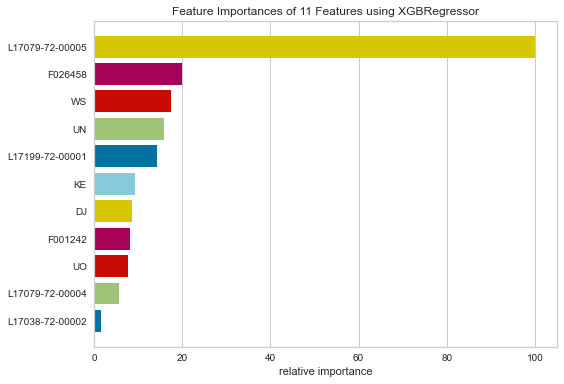

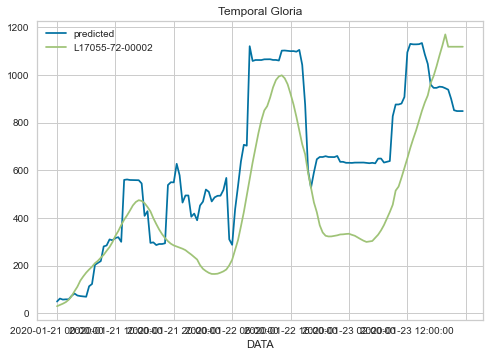

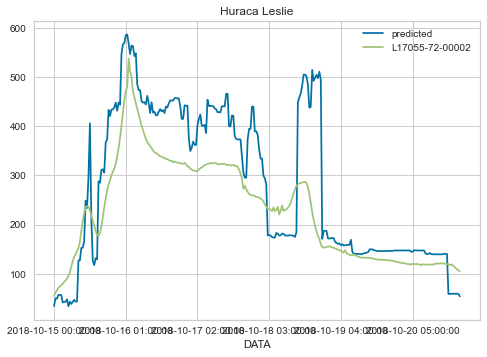

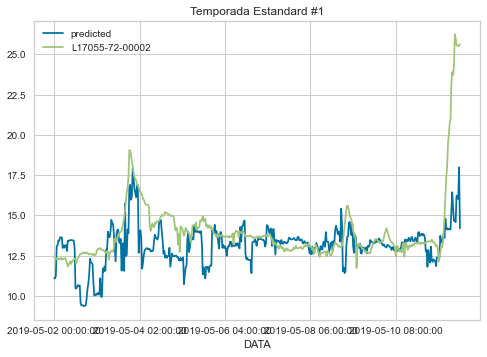

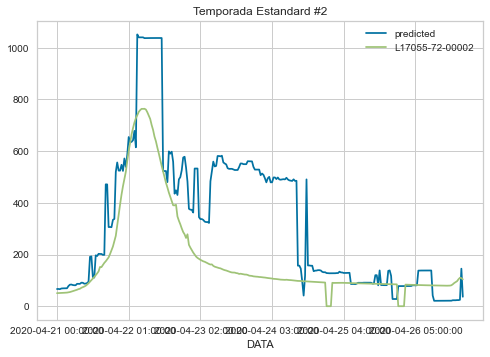

Time:  0:06:21.030982


In [29]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'XGBoost','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [30]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores,RMSE_Leslie,RMSE_Standard1,RMSE_Standard2,RSME_Gloria
0,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.19457417609467156, 0.04548927990487396, 0.1...",0.756907,NaN,1 day,56.824224,3.846712,105.936538,275.321240
1,Random Forest,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1760615586056166, 0.06632250998624659, 0.18...",0.540035,NaN,1 day,62.472393,2.250157,97.057859,221.484833
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.21864924772908742, 0.05323183814057408, 0.1...",0.69618,NaN,1 day,44.909047,2.745626,97.221138,201.039507
3,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.04572711, 0.04404475, 0.027181787, 0.520783...",0.697764,NaN,1 day,93.008098,4.136431,155.782916,300.403374
4,XGBoost,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1335304, 0.064196356, 0.04384175, 0.5467981...",0.69081,NaN,1 day,73.491466,3.127113,146.605297,227.584657
5,XGBoost,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.06828012, 0.095048934, 0.039365087, 0.47893...",0.491906,NaN,1 day,94.130136,2.075736,223.629345,238.598052


# ExtraTrees (Baix Ter)

In [31]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [32]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 1.55 s
Wall time: 8.34 s


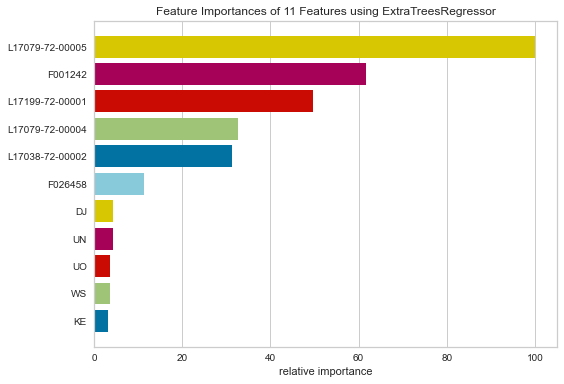

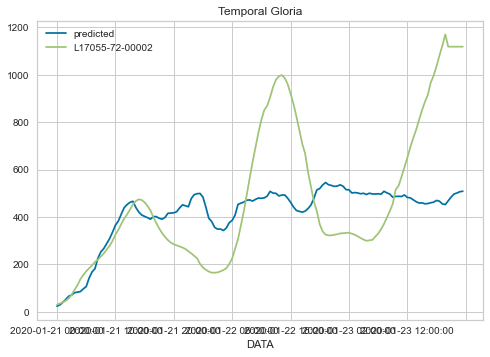

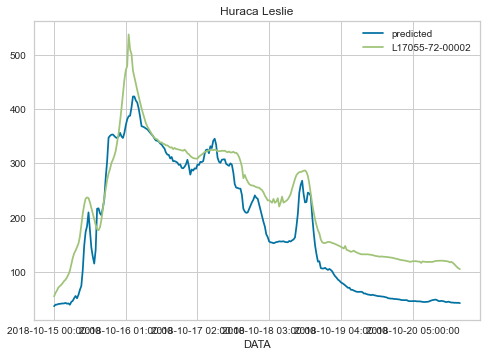

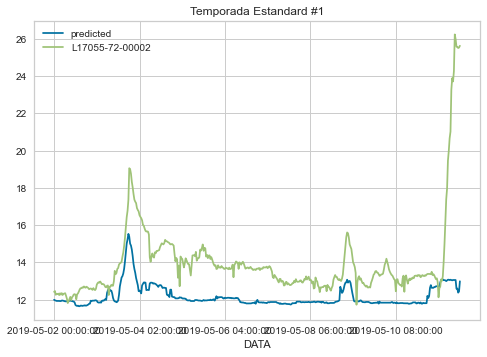

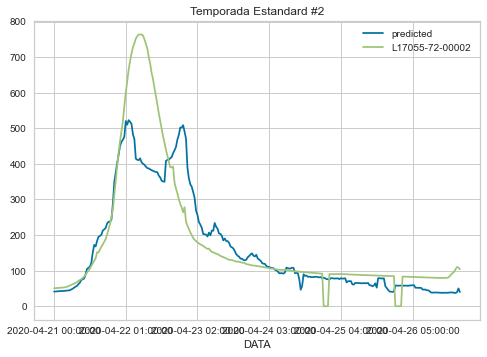

Iteració:  2
CPU times: total: 2.56 s
Wall time: 14.9 s


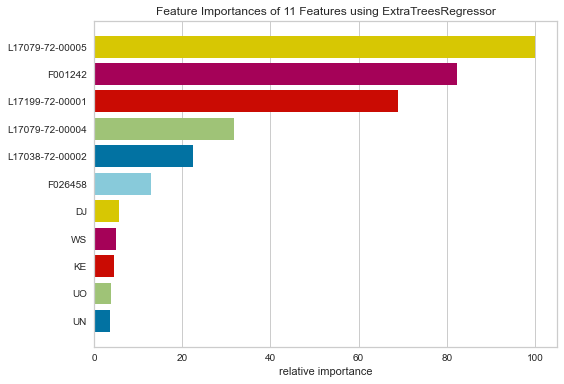

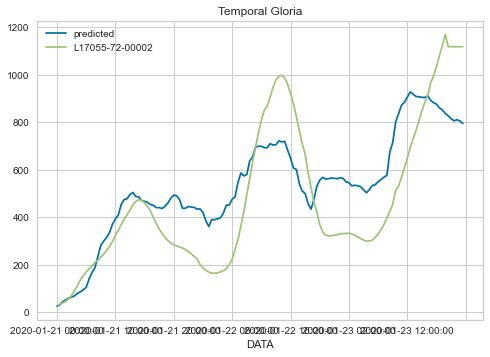

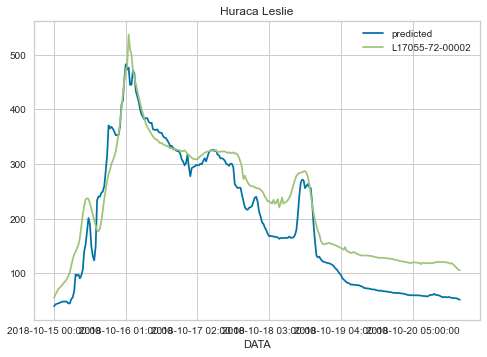

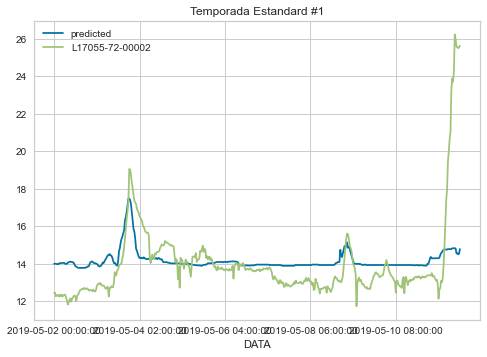

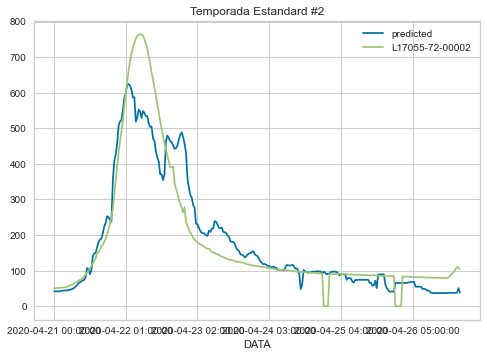

Iteració:  3
CPU times: total: 32.4 s
Wall time: 1min 53s


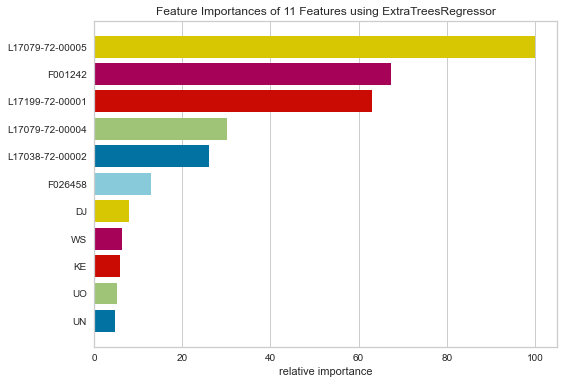

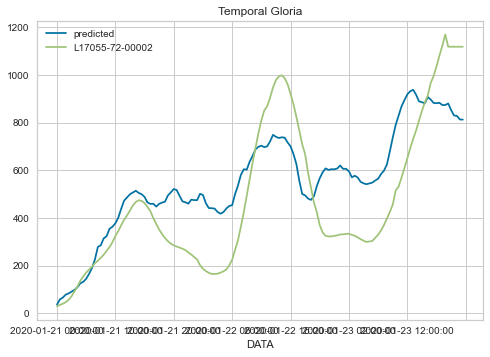

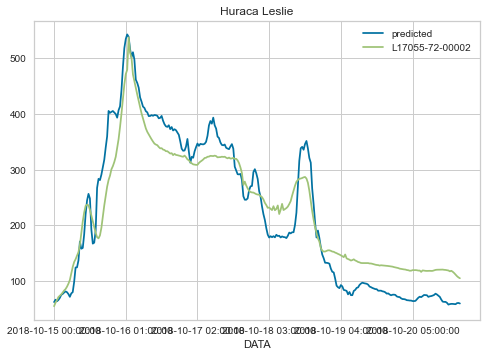

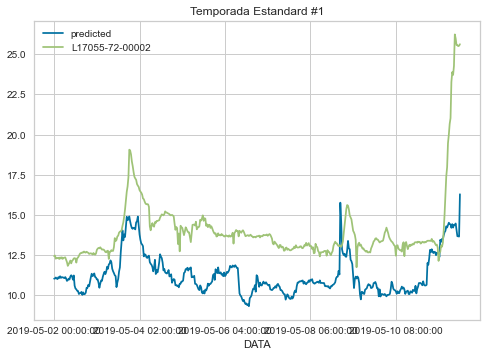

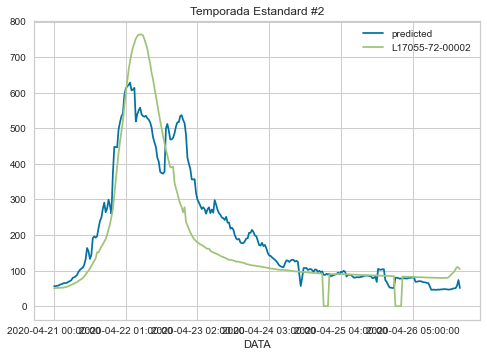

Time:  0:02:21.878103


In [33]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'ExtraTrees','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [34]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores,RMSE_Leslie,RMSE_Standard1,RMSE_Standard2,RSME_Gloria
0,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.19457417609467156, 0.04548927990487396, 0.1...",0.756907,NaN,1 day,56.824224,3.846712,105.936538,275.321240
1,Random Forest,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1760615586056166, 0.06632250998624659, 0.18...",0.540035,NaN,1 day,62.472393,2.250157,97.057859,221.484833
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.21864924772908742, 0.05323183814057408, 0.1...",0.69618,NaN,1 day,44.909047,2.745626,97.221138,201.039507
3,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.04572711, 0.04404475, 0.027181787, 0.520783...",0.697764,NaN,1 day,93.008098,4.136431,155.782916,300.403374
4,XGBoost,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1335304, 0.064196356, 0.04384175, 0.5467981...",0.69081,NaN,1 day,73.491466,3.127113,146.605297,227.584657
5,XGBoost,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.06828012, 0.095048934, 0.039365087, 0.47893...",0.491906,NaN,1 day,94.130136,2.075736,223.629345,238.598052
6,ExtraTrees,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.16263957583547875, 0.03715627969099976, 0.2...",0.725342,NaN,1 day,58.470520,2.598575,96.161193,271.607899
7,ExtraTrees,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.2019563401918953, 0.03767633904047765, 0.24...",0.480185,NaN,1 day,48.418129,1.944798,70.709853,187.510272
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1912497981467665, 0.0393729413197216, 0.204...",0.693951,NaN,1 day,46.186114,3.142720,86.103549,196.453697


# Linear Regression (Baix Ter)

In [35]:
#Carregar del csv
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [36]:
Df_BaixX.set_index('datetime', drop=True, inplace=True)
Df_Baixy.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 0 ns
Wall time: 8.01 ms


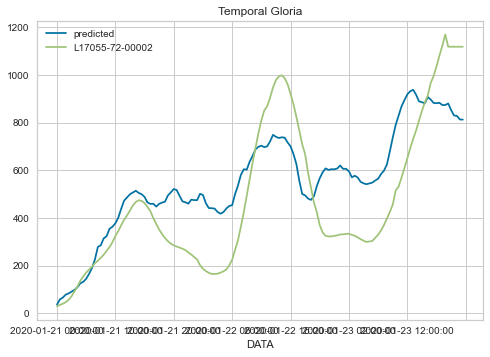

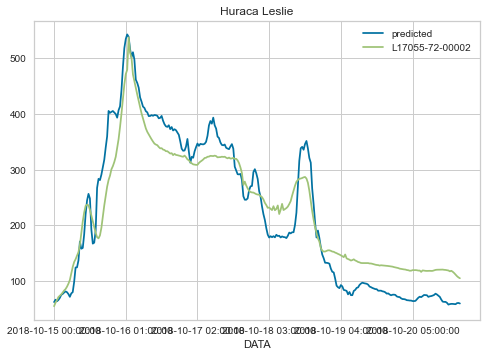

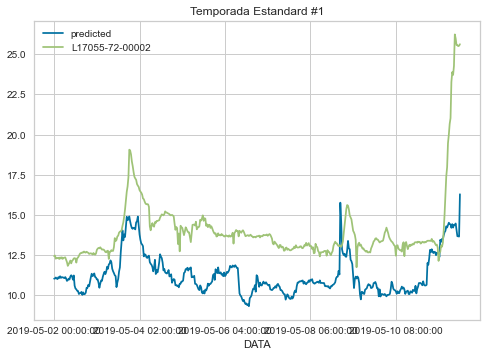

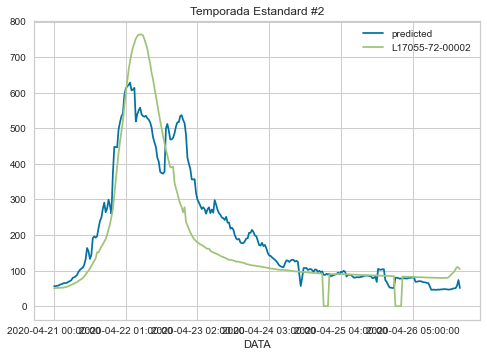

Iteració:  2
CPU times: total: 15.6 ms
Wall time: 15.5 ms


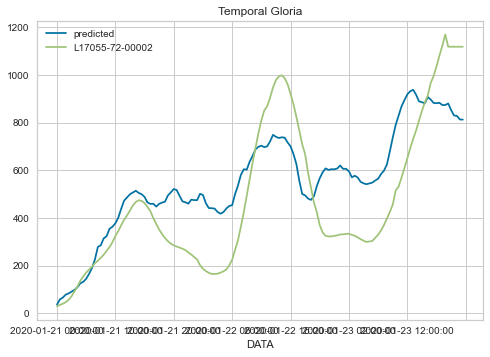

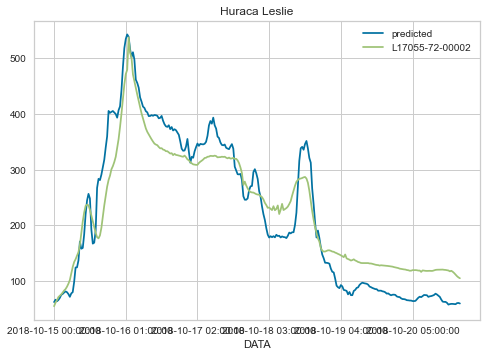

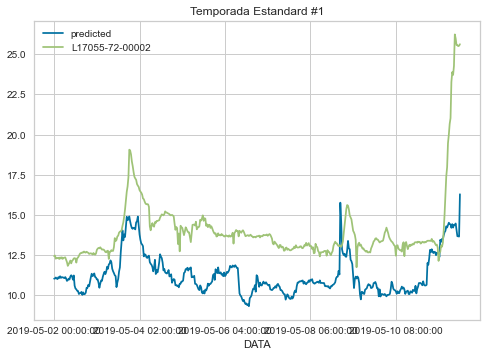

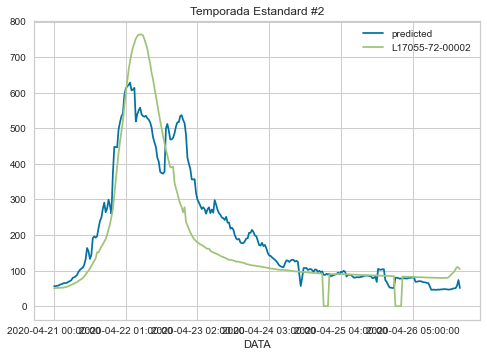

Iteració:  3
CPU times: total: 31.2 ms
Wall time: 27 ms


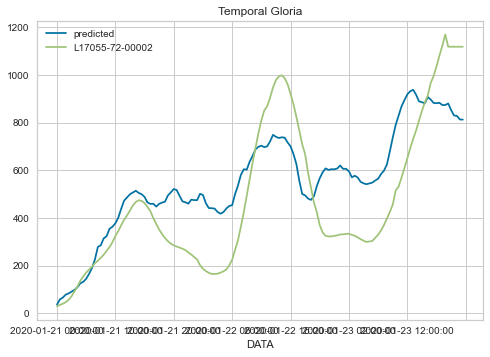

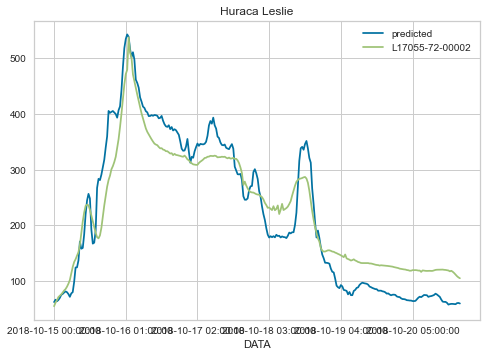

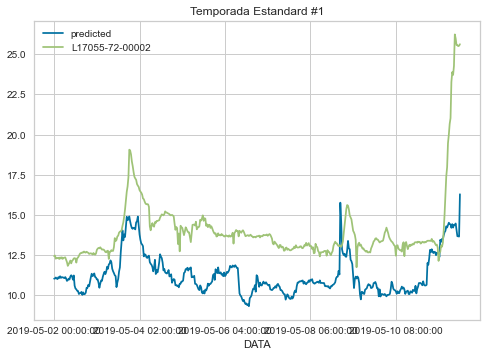

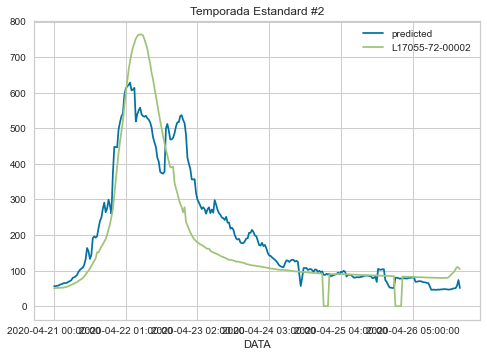

Time:  0:00:01.593788


In [37]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_BaixX_train, Df_Baixy_train)
        
    score = modelfited.score(Df_BaixX_test, Df_Baixy_test)
    
    predicty = modelfited.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    

    hores = "1 day"
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','Best_Params':bestParams, 'Features':Df_BaixX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [38]:
df_results_baixTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores,RMSE_Leslie,RMSE_Standard1,RMSE_Standard2,RSME_Gloria
0,Random Forest,"{'max_depth': 10, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.19457417609467156, 0.04548927990487396, 0.1...",0.756907,NaN,1 day,56.824224,3.846712,105.936538,275.321240
1,Random Forest,"{'max_depth': 8, 'max_features': 1, 'n_estimat...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1760615586056166, 0.06632250998624659, 0.18...",0.540035,NaN,1 day,62.472393,2.250157,97.057859,221.484833
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.21864924772908742, 0.05323183814057408, 0.1...",0.69618,NaN,1 day,44.909047,2.745626,97.221138,201.039507
3,XGBoost,"{'max_depth': 25, 'max_features': 1, 'n_estima...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.04572711, 0.04404475, 0.027181787, 0.520783...",0.697764,NaN,1 day,93.008098,4.136431,155.782916,300.403374
4,XGBoost,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1335304, 0.064196356, 0.04384175, 0.5467981...",0.69081,NaN,1 day,73.491466,3.127113,146.605297,227.584657
5,XGBoost,"{'max_depth': 25, 'max_features': 'log2', 'n_e...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.06828012, 0.095048934, 0.039365087, 0.47893...",0.491906,NaN,1 day,94.130136,2.075736,223.629345,238.598052
6,ExtraTrees,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.16263957583547875, 0.03715627969099976, 0.2...",0.725342,NaN,1 day,58.470520,2.598575,96.161193,271.607899
7,ExtraTrees,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.2019563401918953, 0.03767633904047765, 0.24...",0.480185,NaN,1 day,48.418129,1.944798,70.709853,187.510272
8,ExtraTrees,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1912497981467665, 0.0393729413197216, 0.204...",0.693951,NaN,1 day,46.186114,3.142720,86.103549,196.453697
9,Linear Regression,"{'max_depth': None, 'max_features': 'sqrt', 'n...","Index(['L17199-72-00001', 'F026458', 'F001242'...","[0.1912497981467665, 0.0393729413197216, 0.204...",0.708084,NaN,1 day,46.186114,3.142720,86.103549,196.453697
